Version 2 10/2/2023  
Pipeline to process MERSCOPE experiments as they come in.  
Want to organize sections with only relevant metadata from new services and have ability to attach analysis status.  
To do this, trying out a SpatialDataset Class that will hold this information and could be made into a dashboard.  

The pipeline has the following basic steps:  
1. Pull metadata from new services
2. Assessment of total counts and corrlation to bulkseq
3. Re-segmentation 
4. QC of cells and filtering out low quality ones
5. Creation of AnnData object for primary analysis
6. Mapping with scrattch-mapping
7. First stage analysis of mapping  

This notebook should be able to run by providing the MERSCOPE barcode 

In [1]:
barcode = 1291814104
broad_region = 'Basal Ganglia'

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import importlib
from pathlib import Path
import sawg
from sawg import spatial_dataset as spd

from sawg import ScrattchMapping
from sawg import SpotTable
from sawg import MERSCOPESection

In [3]:
merscope_section = spd.MERSCOPESection(barcode)

SpatialDataset already exists and will be loaded. If you want to reprocess this dataset delete the file and start over
SpatialDataset \\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\spatial_dataset loaded...
Correlation to bulk already calculated: 0.67
Mapping timestamps: 	 Mapping info
1700074043.523: 	 {'mapping_method': 'scrattch mapping', 'taxonomy': '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115', 'sp_data_uns': '{\'qc\': {\'genes\': \'> 8\', \'perc_blanks\': \'< 2%\'}, \'segmentation\': {\'method_args\': {\'options\': {\'cell_dia\': 10, \'cellpose_gpu\': \'auto\', \'cellpose_model\': \'/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope\', \'cellpose_options\': {\'batch_size\': 8}, \'images\': {\'cyto\': {\'channel\': \'total_mrna\', \'frame\': 3, \'n_planes\': 7}, \'nuclei\': {\'channel\': \'DAPI\', \'frame\': 3}}, \'px_size\': 

In [4]:
merscope_section.broad_region = broad_region
merscope_section.save_dataset()

1. Load detected transcripts, calculate total counts, and correlate to bulk-seq. Look at some marker genes and zoom in for
sanity check

Loading from npz..


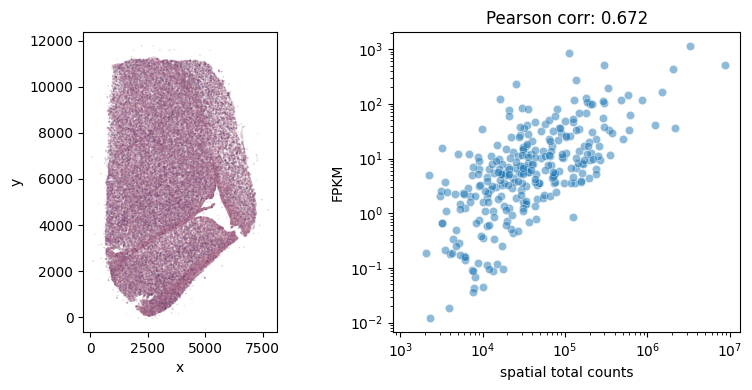

In [5]:
merscope_section.spatial_corr_to_bulk()

Loading from npz..


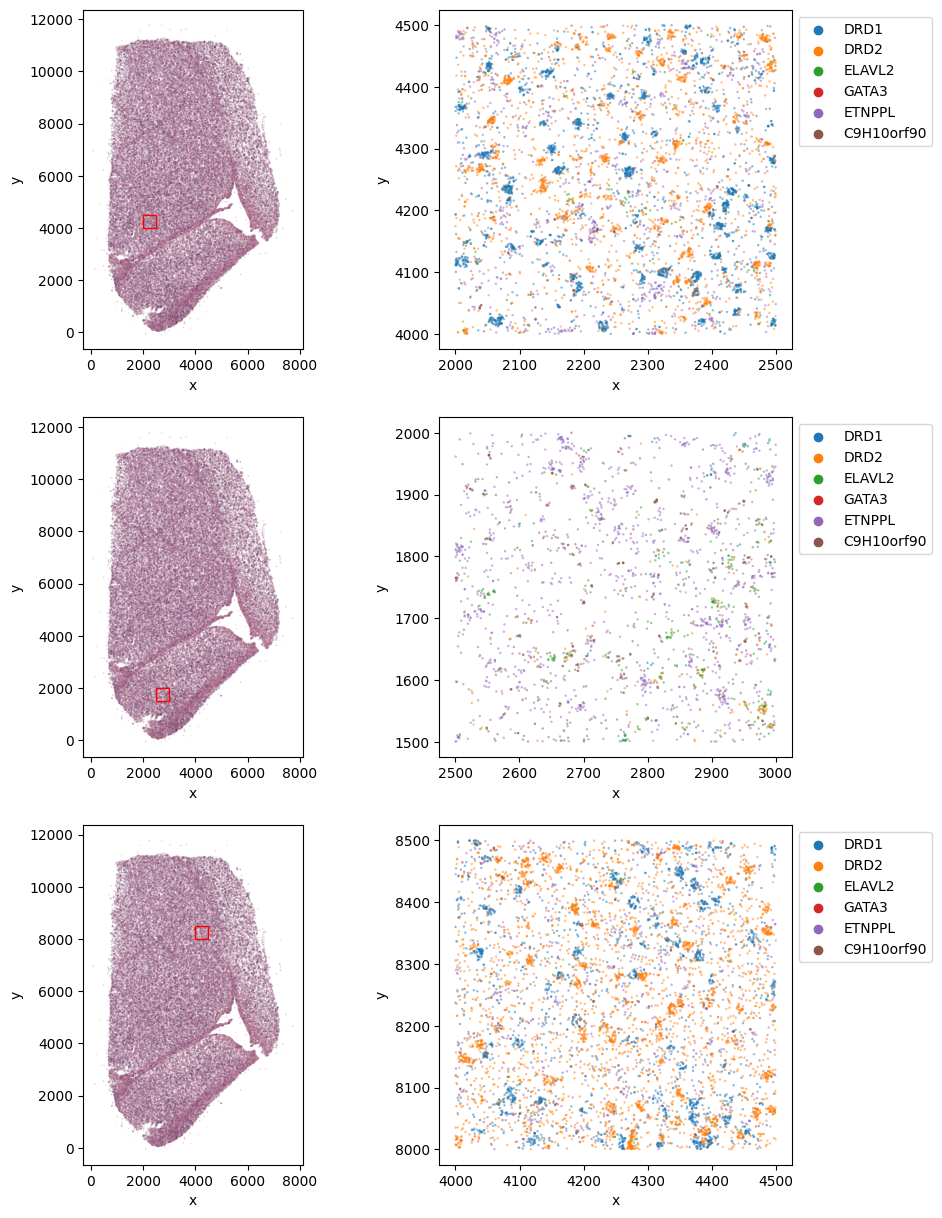

In [6]:
genes = ['DRD1', 'DRD2', 'ELAVL2', 'GATA3', 'ETNPPL', 'C9H10orf90']  
subregions = [
    ((2000, 2500), (4000, 4500)),
    ((2500, 3000), (1500, 2000)),
    ((4000, 4500), (8000, 8500))
]

merscope_section.show_gene_transcripts(genes=genes, subregions=subregions)

2. Resegment cells
- Load Segmentation Class
- Run model of choice
- Save results

3. Format anndata and QC cells  
- Calculate QC metrics and stick in obs  
    Current parameters for qc'ing include:  
    - '>' 8 genes
    - < 2% blanks
- Add probe type to var
    - also add whether the gene is one used for cell QC?
- Add log transformed layer
- Save updated cbg in main directory as sp_ad to follow previous workflow

In [35]:
## for now load up previously run segmentation (which we will need a way to implement anyway)
import anndata
cbg = anndata.read_h5ad(f"{merscope_section.save_path}/{merscope_section.config['segmentation_dir']}/2D/cell_by_gene.h5ad")

In [36]:
import numpy as np
gene_cols = [col for col in cbg.var_names if not col.startswith('Blank')]
blank_cols = [col for col in cbg.var_names if col.startswith('Blank')]
cbg.obs['n_transcripts'] = np.sum(cbg[:, gene_cols].X, axis=1)
cbg.obs['n_genes'] = np.sum(cbg[:,gene_cols].X > 0, axis=1)
cbg.obs['n_blanks'] = np.sum(cbg[:, blank_cols].X, axis=1)
cbg.obs['perc_blanks'] = cbg.obs['n_blanks'] / cbg.obs['n_transcripts'] * 100
cbg.obs.replace(to_replace={'perc_blanks': {np.inf: 100}}, inplace=True)

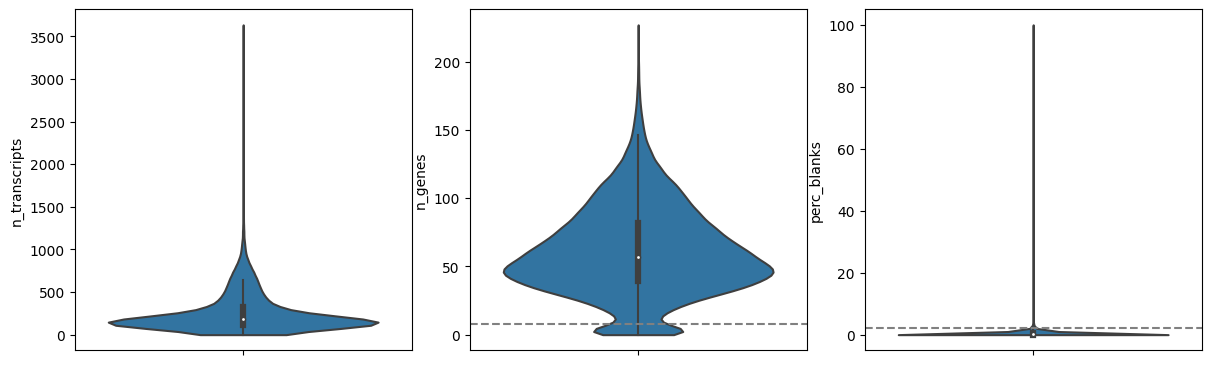

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
plt.tight_layout()

sns.violinplot(data=cbg.obs, y='n_transcripts', cut=0, ax=ax[0])
sns.violinplot(data=cbg.obs, y='n_genes', cut=0, ax=ax[1])
ax[1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg.obs, y='perc_blanks', cut=0, ax=ax[2])
ax[2].axhline(2, color='grey', ls='--')

In [39]:
cbg.obs.describe()

x             y  n_transcripts       n_genes      n_blanks  \
count  66009.000000  66009.000000   66009.000000  66009.000000  66009.000000   
mean    3586.489502   5944.679199     254.036025     61.565105      1.025709   
std     1657.246338   2922.950439     227.806124     32.790183      1.460896   
min      361.989868    -60.927124       0.000000      0.000000      0.000000   
25%     2206.430664   3486.849365     110.000000     39.000000      0.000000   
50%     3489.872559   5896.309570     183.000000     57.000000      1.000000   
75%     4881.098145   8426.953125     321.000000     82.000000      2.000000   
max     7741.764160  11548.279297    3636.000000    227.000000     26.000000   

        perc_blanks  
count  66009.000000  
mean       0.452101  
std        1.620776  
min        0.000000  
25%        0.000000  
50%        0.155763  
75%        0.613497  
max      100.000000

In [43]:
cbg.obs['min_gene_qc'] = cbg.obs.apply(lambda x: x['n_genes'] > 8, axis=1)
cbg.obs['perc_blanks_qc'] = cbg.obs.apply(lambda x: x['perc_blanks'] < 2, axis=1)

Text(0.5, 1.0, 'Remaining Cells: 62753')

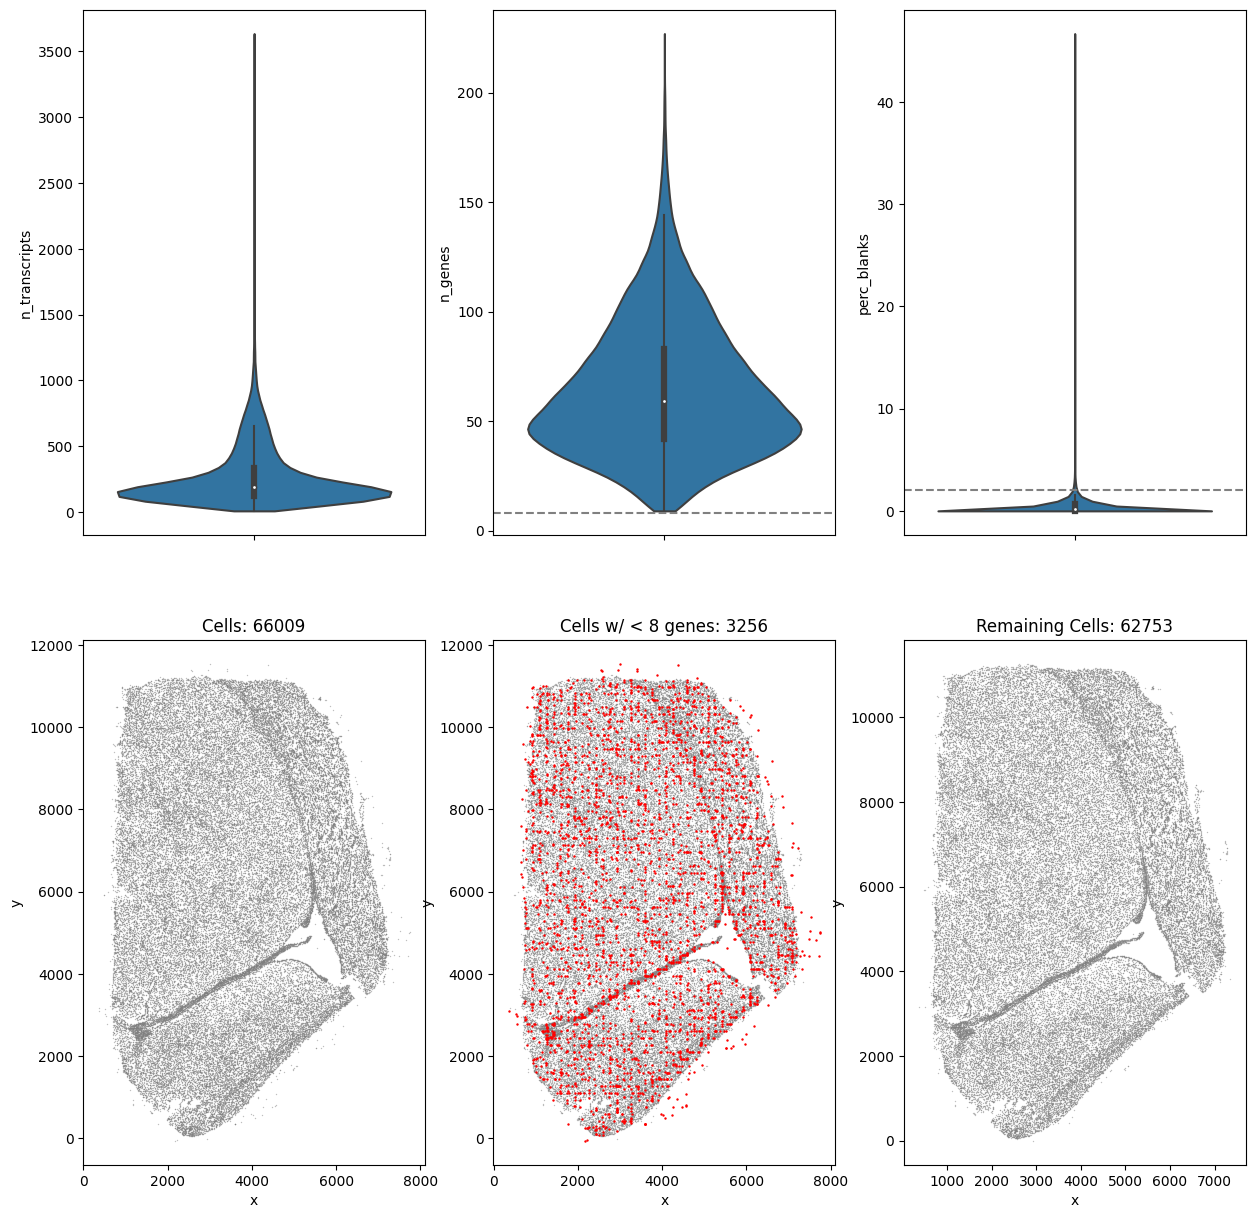

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))

cbg_filt = cbg.obs[cbg.obs['min_gene_qc']]

sns.violinplot(data=cbg_filt, y='n_transcripts', cut=0, ax=ax[0, 0])
sns.violinplot(data=cbg_filt, y='n_genes', cut=0, ax=ax[0, 1])
ax[0, 1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg_filt, y='perc_blanks', cut=0, ax=ax[0, 2])
ax[0, 2].axhline(2, color='grey', ls='--')

sns.scatterplot(data=cbg.obs, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 0], linewidth=0)
ax[1, 0].set_title(f'Cells: {len(cbg.obs)}')
sns.scatterplot(data=cbg.obs, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 1], linewidth=0)
sns.scatterplot(data=cbg.obs[~cbg.obs['min_gene_qc']], x='x', y='y', color='red', s=3, ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title(f'Cells w/ < 8 genes: {len(cbg.obs) - len(cbg_filt)}')
sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 2], linewidth=0)
ax[1, 2].set_title(f'Remaining Cells: {len(cbg_filt)}')

Text(0.5, 1.0, 'Remaining Cells: 61078')

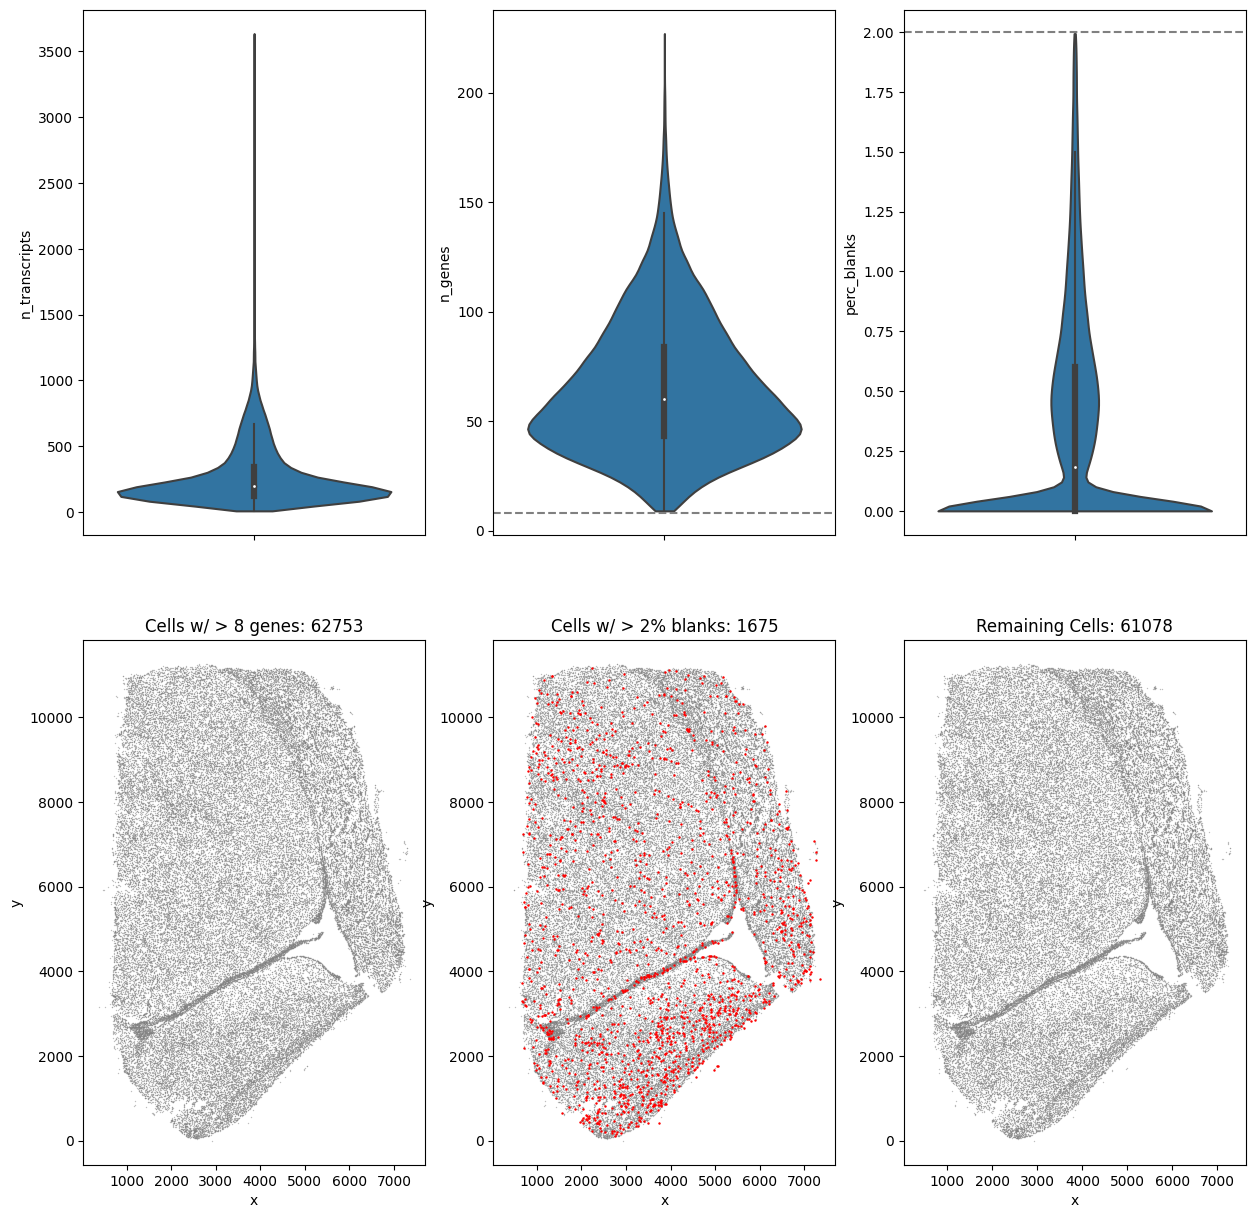

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))

cbg_filt2 = cbg_filt[cbg_filt['perc_blanks_qc']]

sns.violinplot(data=cbg_filt2, y='n_transcripts', cut=0, ax=ax[0, 0])
sns.violinplot(data=cbg_filt2, y='n_genes', cut=0, ax=ax[0, 1])
ax[0, 1].axhline(8, color='grey', ls='--')
sns.violinplot(data=cbg_filt2, y='perc_blanks', cut=0, ax=ax[0, 2])
ax[0, 2].axhline(2, color='grey', ls='--')

sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 0], linewidth=0)
ax[1, 0].set_title(f'Cells w/ > 8 genes: {len(cbg_filt)}')
sns.scatterplot(data=cbg_filt, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 1], linewidth=0)
sns.scatterplot(data=cbg_filt[~cbg_filt['perc_blanks_qc']], x='x', y='y', color='red', s=3, ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title(f'Cells w/ > 2% blanks: {len(cbg_filt) - len(cbg_filt2)}')
sns.scatterplot(data=cbg_filt2, x='x', y='y', color='grey', s=1, alpha=0.5, ax=ax[1, 2], linewidth=0)
ax[1, 2].set_title(f'Remaining Cells: {len(cbg_filt2)}')

In [48]:
cbg_filt2.describe()

x             y  n_transcripts       n_genes      n_blanks  \
count  61078.000000  61078.000000   61078.000000  61078.000000  61078.000000   
mean    3584.493652   5972.719238     271.505861     65.297783      1.022741   
std     1654.455078   2914.536621     227.342674     30.651897      1.409781   
min      376.038086     -6.414886       9.000000      9.000000      0.000000   
25%     2206.006165   3538.350220     124.000000     43.000000      0.000000   
50%     3486.638306   5932.873047     195.000000     60.000000      1.000000   
75%     4875.453369   8440.529297     342.000000     84.000000      2.000000   
max     7284.946289  11270.193359    3636.000000    227.000000     19.000000   

        perc_blanks  
count  61078.000000  
mean       0.353724  
std        0.443050  
min        0.000000  
25%        0.000000  
50%        0.183824  
75%        0.598802  
max        1.993355

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\spatialtx\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\spatialtx\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\spatialtx\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn

In [13]:
cbg.var['probe_type'] = None
cbg.var['probe_type'] = cbg.var.apply(lambda x: 'blank' if x.name.startswith('Blank') else 'gene', axis=1)

In [14]:
cbg.layers['logcounts'] = np.log1p(cbg.X)

In [15]:
import pickle as pkl

with open(f"{merscope_section.save_path}/{merscope_section.config['segmentation_dir']}/2D/run_spec.pkl", 'rb') as file:
            run_spec = pkl.load(file)
            file.close()

In [16]:
cbg.obs['cell_qc'] = cbg.obs.apply(lambda x: 'pass' if x['min_gene_qc'] and x['perc_blanks_qc'] else 'fail', axis=1)
cbg.uns.update(
{
    'qc': {'genes': '> 8', 'perc_blanks': '< 2%'},
    'segmentation': {'method_class': str(run_spec[0][-1]['method_class']), 'method_args': run_spec[0][-1]['method_args']}
}
)

In [17]:
cbg.uns

OrderedDict([('qc', {'genes': '> 8', 'perc_blanks': '< 2%'}),
             ('segmentation',
              {'method_class': "<class 'sawg.segmentation.CellposeSegmentationMethod'>",
               'method_args': {'options': {'region': None,
                 'cellpose_model': '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope',
                 'cellpose_gpu': 'auto',
                 'px_size': 0.108,
                 'cell_dia': 10,
                 'z_plane_thickness': 1.5,
                 'images': {'cyto': {'channel': 'total_mrna',
                   'n_planes': 7,
                   'frame': 3},
                  'nuclei': {'channel': 'DAPI', 'frame': 3}},
                 'cellpose_options': {'batch_size': 8}}}})])

In [18]:

sp_anndata_path = merscope_section.save_path.joinpath('sp_anndata.h5ad')
cbg.write_h5ad(sp_anndata_path)
merscope_section.anndata = sp_anndata_path
merscope_section.save_dataset()

4. Map with ScrattchMapping
- Create ScrattchMapping object
- Flag to only map QC pass cells? (ie ad_map will only have qc_pass cells but original cbg is retained)

In [19]:
map_args = {'ad_sp_layer': 'logcounts', 'cell_qc': 'cell_qc'}
hpc_args = {'docker': 'singularity exec --cleanenv docker://njjai/scrattch_mapping:0.51'}

job, mapping = merscope_section.run_mapping_on_section(ScrattchMapping, 'AIT115', method_args=map_args, hpc_args=hpc_args)

loading spatial data from \\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\sp_anndata.h5ad...
Setting run directory to //allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1291814104/mapping
Mapping UID: 1700589289.094
building HPC job
<JobState RUNNING> 12294466


In [23]:
job.state()

<JobState RUNNING>

5. Do some basic analysis and make some plots
- Mapping probability distributions
- Mapping scatter plots, cluster level grouped by neighborhood
- Make cirro object for interactive viewing locally?

In [5]:
merscope_section.get_mappings()

1700074043.523: {'mapping_method': 'scrattch mapping', 'taxonomy': '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115', 'sp_data_uns': '{\'qc\': {\'genes\': \'> 8\', \'perc_blanks\': \'< 2%\'}, \'segmentation\': {\'method_args\': {\'options\': {\'cell_dia\': 10, \'cellpose_gpu\': \'auto\', \'cellpose_model\': \'/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope\', \'cellpose_options\': {\'batch_size\': 8}, \'images\': {\'cyto\': {\'channel\': \'total_mrna\', \'frame\': 3, \'n_planes\': 7}, \'nuclei\': {\'channel\': \'DAPI\', \'frame\': 3}}, \'px_size\': 0.108, \'z_plane_thickness\': 1.5}}, \'method_class\': "<class \'sawg.segmentation.CellposeSegmentationMethod\'>"}}', 'counts': 'logcounts'}
1700174275.071: {'mapping_method': 'scrattch mapping', 'taxonomy': '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115', 'sp_data_uns': '{\'qc\': {\'genes\': \'> 8

loading results...
No scrattch_map_temp.h5ad file found in run directory, checking for previously saved results...


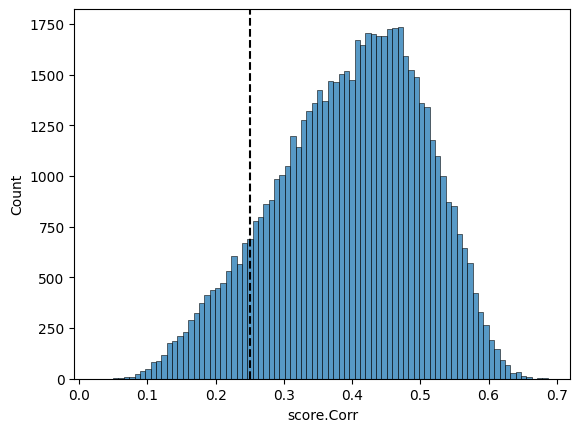

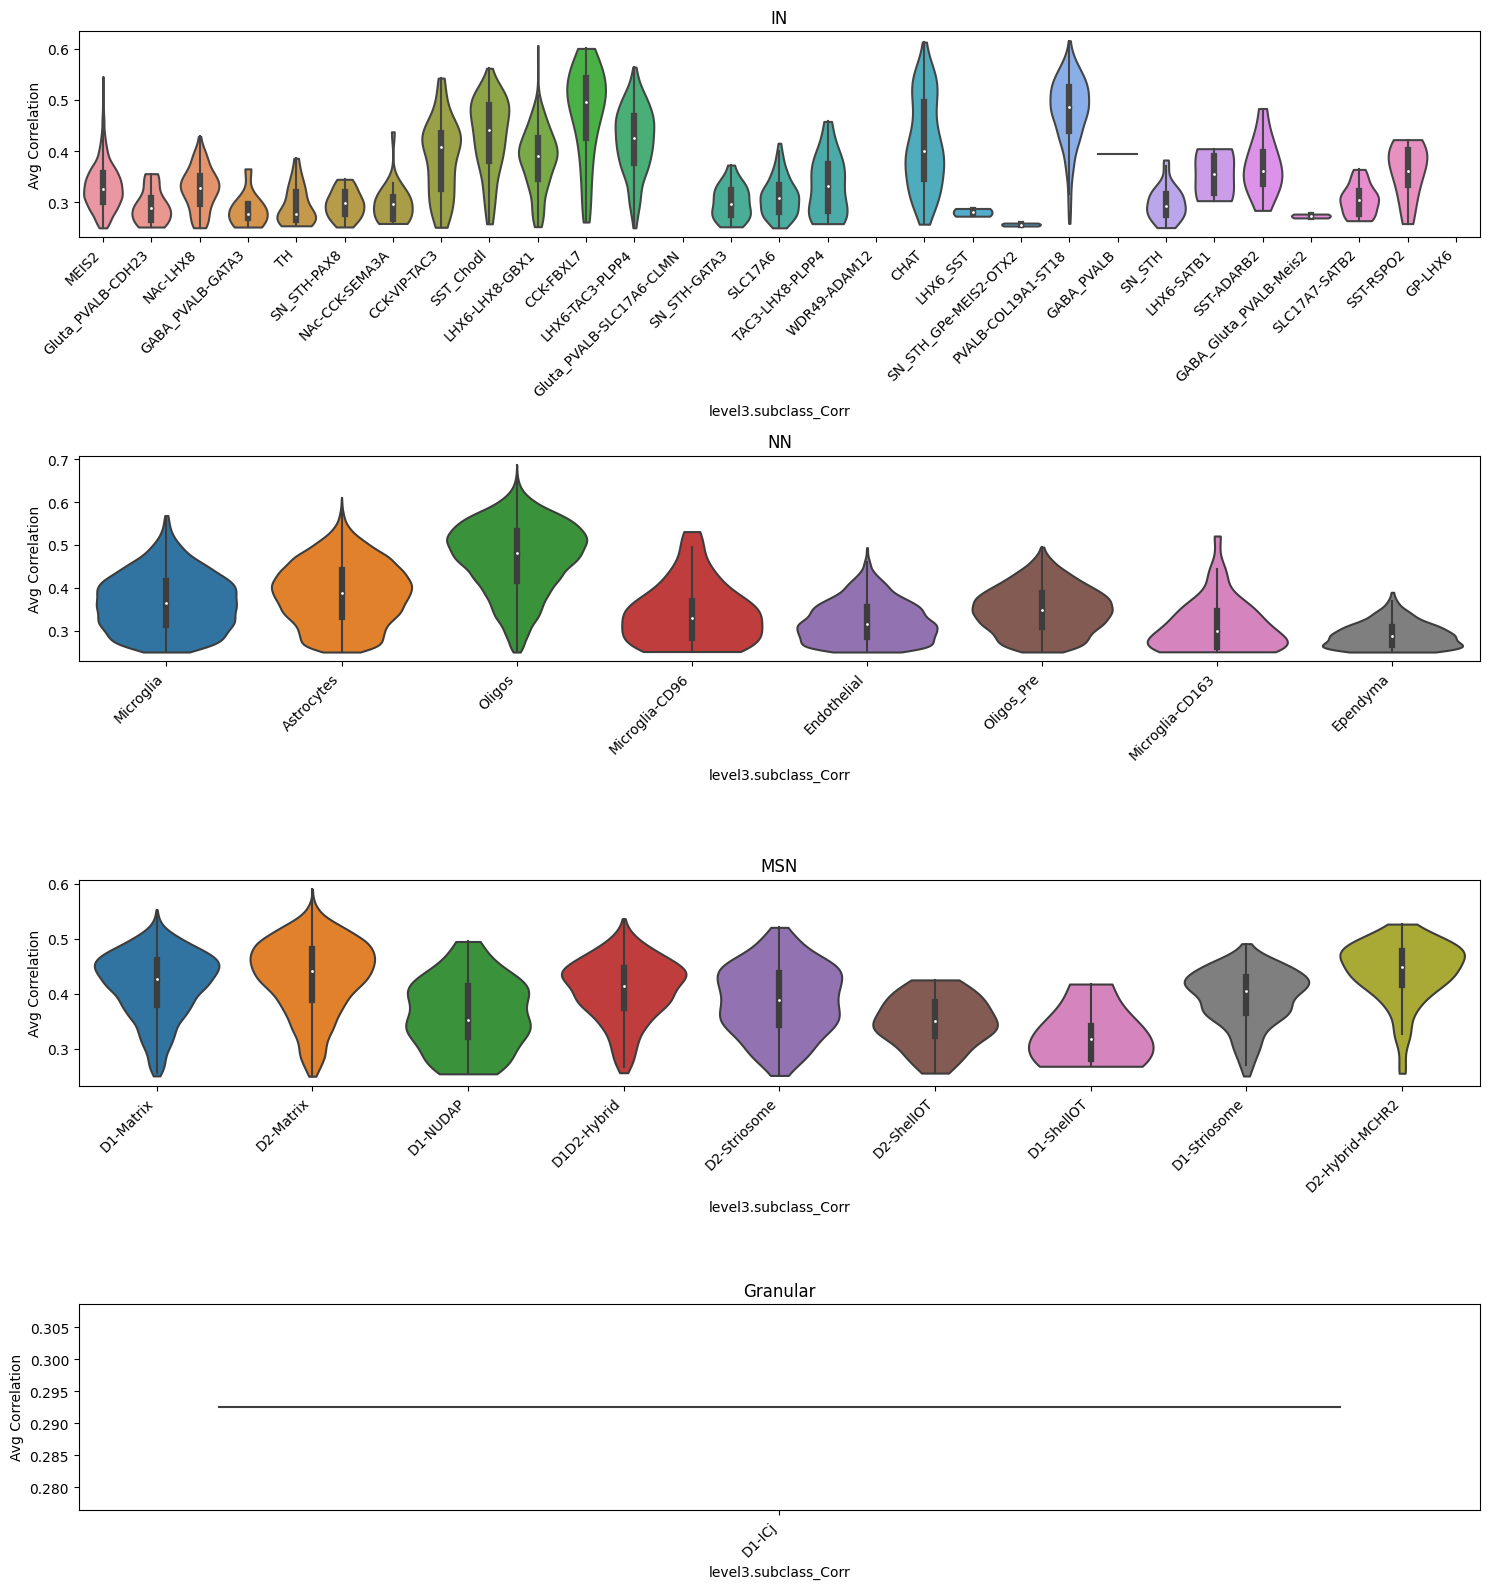

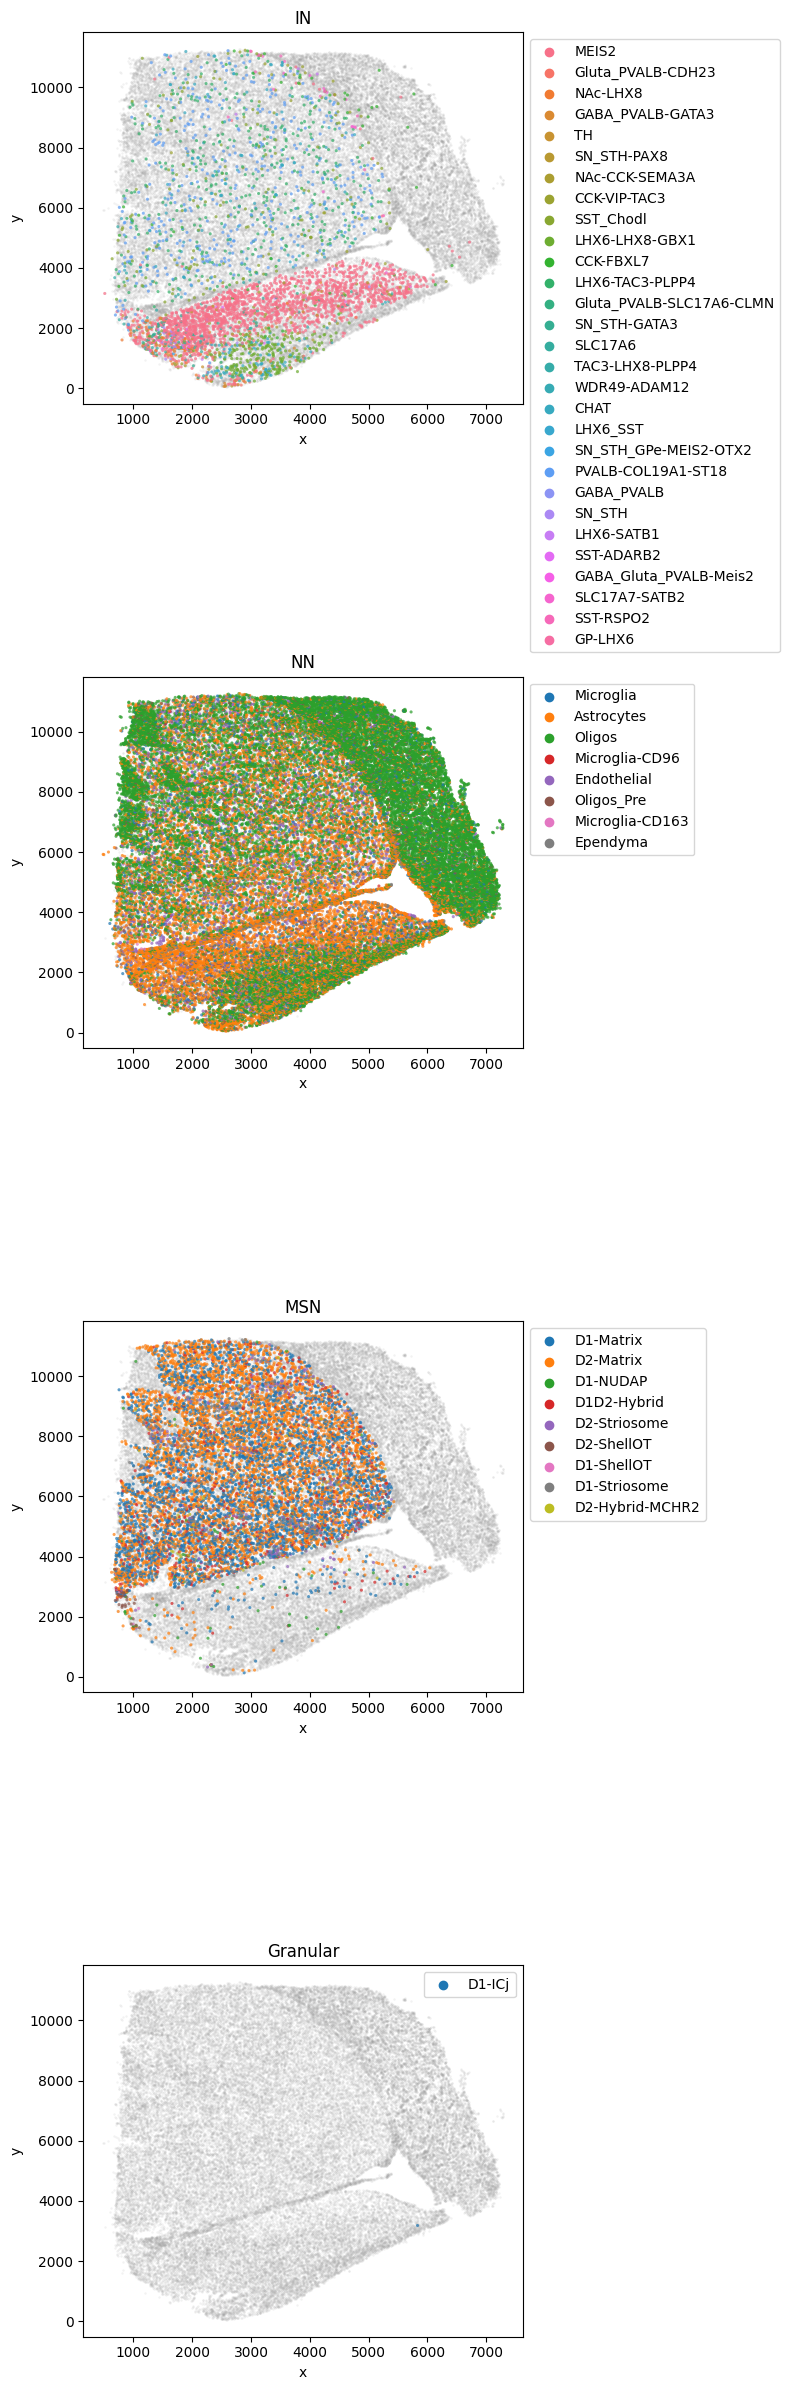

In [6]:
merscope_section.view_mapping_results('1700174275.071', 'subclass', score_thresh=0.25)

Make Cirro files for viewing (optional)  
Run `cirro launch [cirro_file]` from commmand window

In [4]:
cirro_file = merscope_section.make_cirro('1700174275.071')

\\allen\programs\celltypes\workgroups\rnaseqanalysis\NHP_spatial\MERSCOPE\macaque\1291814104\mapping\1700174275.071\ad_cirro_QM23.50.001.CX.44.01.05.03.h5ad
